In [1]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from joblib import dump, load
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from ipywidgets import HBox, widgets, Layout, Button
from IPython.display import display, HTML
import base64

from board_utils import *

In [2]:
def games_from_drive():
    max_games = 500000 
    asset_dir = 'asset'
    file_name = '2023_tc_500000_games.pgn'

    gauth = GoogleAuth()
    gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
    gauth.LoadCredentialsFile("mycreds.txt")
    if gauth.credentials is None:
        gauth.LocalWebserverAuth()
    elif gauth.access_token_expired:
        gauth.Refresh()
    else:
        gauth.Authorize()

    gauth.SaveCredentialsFile("mycreds.txt")
    drive = GoogleDrive(gauth)

    def load_pgns_from_text(pgns_text, num_games=None, start_index=0, encoding="utf-8"):
        games = []
        file_io = io.StringIO(pgns_text)
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
            games.append(game)
        return games

    def find_folder_id(folder_name):
        file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
        for file in file_list:
            if file['title'] == folder_name:
                return file['id']
        return None

    def read_pgn_file_from_drive(file_title, parent_id):
        query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
        file_list = drive.ListFile({'q': query}).GetList()
        if not file_list:
            print(f"No file found with title: {file_title}")
            return None
        file = file_list[0]
        urls = file.GetContentString(encoding='UTF-8')
        return urls

    chess_games_loaded = False
    print("loading pgn...")
    asset_folder_id = find_folder_id(asset_dir)

    if asset_folder_id is None:
        print("Asset folder not found.")
    else:
        pgns_text = read_pgn_file_from_drive(file_name, asset_folder_id)
        games = load_pgns_from_text(pgns_text, num_games=max_games)
        if games is not None:
            print("pgn file loaded successfully.")
    return games

In [3]:
def load_pgns(file_path, num_games=None, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

In [4]:
assets_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
single_path = os.path.join(assets_path, 'kgames_sample.pgn')
games = load_pgns(single_path, 1000)
#games = games_from_drive()

Loading games: 100%|██████████| 1000/1000 [00:03<00:00, 316.45game/s]


In [5]:
game_csr_matrices = [game_to_csr_matrix(game) for game in games]
game_lengths = [mat.shape[0] for mat in game_csr_matrices]
all_board_csr_matrix = vstack(game_csr_matrices)
cumulative_lengths = np.cumsum(game_lengths)

In [6]:
n_components = 100
plot_matrix = all_board_csr_matrix[:, :-2]
fen_idf_matrix_norm = apply_norm_and_idf(plot_matrix)
svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
fens_reduced = svd.fit_transform(fen_idf_matrix_norm)

In [7]:
def fen_to_img_html(fen, size=500):
    board = chess.Board(fen)
    svg = chess.svg.board(board, size=size)
    svg_bytes = svg.encode('utf-8')
    b64_svg = base64.b64encode(svg_bytes).decode('utf-8')
    return f'<img src="data:image/svg+xml;base64,{b64_svg}" style="max-width:100%; height: auto;"/>'

def get_fen_string(index, mat):
    vector = reverse_orient_board(mat[index].toarray()[0])
    return vector_to_fen(vector)

def index_to_endgame_status(ind, mat):
    piece_materials = mat[ind].toarray()[0][-11:-2]
    piece_materials[4] = 0
    if sum(piece_materials) < 4:
        return 'endgame'
    else:
        return '' 

def game_ind_from_pos_ind(position_index):
    return np.searchsorted(np.cumsum(game_lengths), position_index, side='right')

lightest_color = '#cdb688'
darkest_color = '#c5a771'
walnut = [[0, lightest_color],[1, darkest_color]]

pca_3d = PCA(n_components=3)
reduced_data_pca_3d = pca_3d.fit_transform(fens_reduced)

original_size = 5
original_opacity = 0.1

#hover_text_3d = [f'FEN: {get_fen_string(i, plot_matrix)}' for i in range(len(reduced_data_pca_3d))]
hover_text_3d = [f'{index_to_endgame_status(i, plot_matrix)}' for i in range(len(reduced_data_pca_3d))]

fig = go.Figure(data=[go.Scatter3d(
    x=reduced_data_pca_3d[:, 0],
    y=reduced_data_pca_3d[:, 1],
    z=reduced_data_pca_3d[:, 2],
    mode='markers',
    marker=dict(
        size=original_size,
        opacity=original_opacity,
        color=list(range(len(reduced_data_pca_3d))),
        colorscale=walnut,
    ),
    hoverinfo='text',
    text=hover_text_3d
)])

fig.update_layout(
    width=500,
    height=500,
    scene=dict(
        xaxis_title='PC X',
        yaxis_title='PC Y',
        zaxis_title='PC Z'
    ),
    margin=dict(r=0, b=0, l=0, t=0)
)

fig_widget = go.FigureWidget(fig)
chessboard_display = widgets.HTML()

def update_chessboard(trace, points, _):
    if points.point_inds:
        index = points.point_inds[0]
        game_index = game_ind_from_pos_ind(index)

        fen = get_fen_string(index, plot_matrix)
        chessboard_display.value = fen_to_img_html(fen)

        game_start_index = np.cumsum(game_lengths)[game_index - 1] if game_index > 0 else 0
        game_end_index = np.cumsum(game_lengths)[game_index]

        size = [3*original_size if game_start_index <= i < game_end_index else 0 for i in range(len(reduced_data_pca_3d))]

        with fig_widget.batch_update():
            fig_widget.data[0].marker.size = size
            fig_widget.data[0].marker.opacity = 1
            fig_widget.data[0].marker.line.width = 0.01
            fig_widget.data[0].marker.line.color = 'black'

def revert_to_original(_):
    with fig_widget.batch_update():
        fig_widget.data[0].marker.size = [2*original_size] * len(reduced_data_pca_3d)
        fig_widget.data[0].marker.opacity = original_opacity
        fig_widget.data[0].marker.line.width = 0

revert_button = Button(description="Revert to Original")
revert_button.on_click(revert_to_original)

for trace in fig_widget.data:
    trace.on_hover(update_chessboard)

widgets_layout = HBox([fig_widget, chessboard_display, revert_button], layout=Layout(justify_content='space-between', padding='100px'))
display(widgets_layout)

    'data': [{'hoverinfo': 'text',
              'marker': {'color': [0, 1, 2, .…

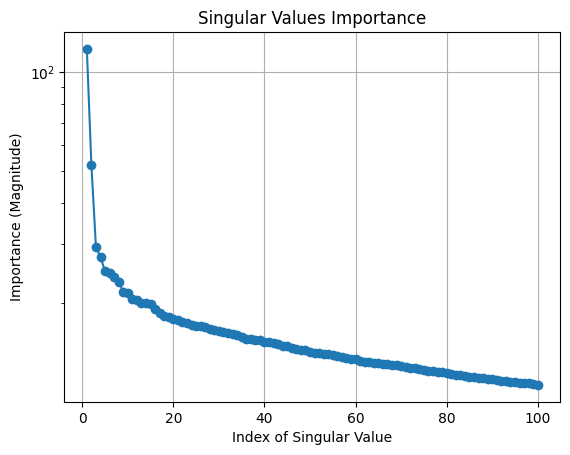

In [8]:
plt.plot(range(1,n_components+1), svd.singular_values_, marker='o')
plt.title('Singular Values Importance')
plt.xlabel('Index of Singular Value')
plt.ylabel('Importance (Magnitude)')
plt.yscale('log')
plt.grid(True)
plt.show()

In [9]:
#query_fen = 'rnb2b1r/2Nnkppp/p2pp3/8/PPBN1P2/2p3Pq/4Q2P/R3K1R1 w Q - 1 17' #wild opening
#query_fen = 'rnbq1rk1/pp2ppbp/3p1np1/8/3NP3/2N1BP2/PPP3PP/R2QKB1R w KQ - 1 8' #dragon
#query_fen = 'r1bq1rk1/ppp2pbp/2np1np1/4p3/2PPP3/2N2N2/PP2BPPP/R1BQ1RK1 w - - 2 8' #kid
#query_fen = '6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 2 36' #knight rook endgame
query_fen = 'r4rk1/ppqn1ppp/3bpn2/3pN3/3P4/2P2N2/PP2QPPP/R1B1R1K1 b - - 4 12' #carlsbad caro
query_fen = 'r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 2 12' #carlsbad
query_array = board_to_array(chess.Board(fen=query_fen))
query_array = orient_board(query_array, query_fen.split()[1]=='w')
transformed_query_array = apply_query_transformations(query_array[:-2], plot_matrix)
query_array_reduced = svd.transform(transformed_query_array.reshape(1, -1))

In [10]:
k=25

norm_X_reduced = fens_reduced / np.linalg.norm(fens_reduced, axis=1, keepdims=True)
norm_query_vector_reduced = query_array_reduced / np.linalg.norm(query_array_reduced)

cos_similarities = 1 - cdist(norm_X_reduced, norm_query_vector_reduced, metric='cosine')
cos_similarities = cos_similarities.flatten()

top_k_indices = np.argsort(cos_similarities)[-k:][::-1]

cos_similarities[top_k_indices]

array([0.87703143, 0.82595188, 0.8201572 , 0.80893906, 0.8032246 ,
       0.79868797, 0.78244577, 0.77815642, 0.77548282, 0.76852047,
       0.76347978, 0.76323294, 0.76200713, 0.76068706, 0.75647105,
       0.75624298, 0.7533288 , 0.75268419, 0.75180584, 0.75106243,
       0.74909245, 0.74874065, 0.74525117, 0.73984661, 0.73903815])

r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1


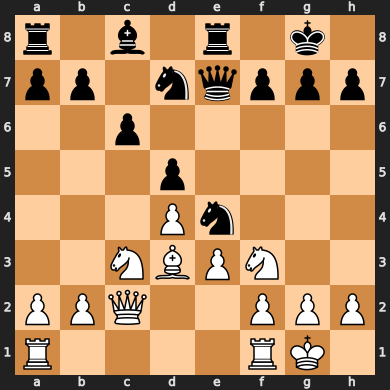

----------------------------------------------------------------
r4rk1/ppq2pp1/2nbpn1p/3pN3/3P4/2P3B1/PP1NQPPP/R3K2R b KQ - 0 1


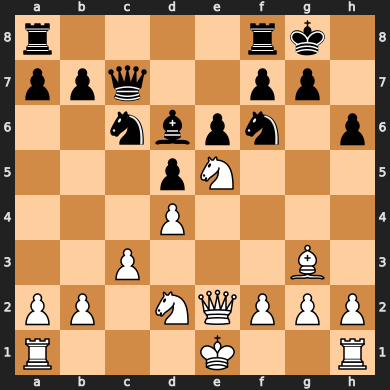

r4rk1/1pqn1ppp/p2bp3/3p4/3P4/2P3P1/PP1NQPPN/R3R1K1 b - - 0 1


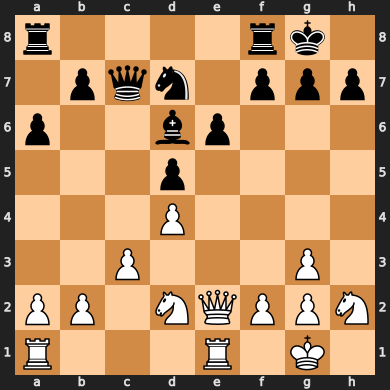

r4rk1/ppq2pp1/2nbp2p/3pN3/3P4/2P3B1/PP2QPPP/R3K2R b KQ - 0 1


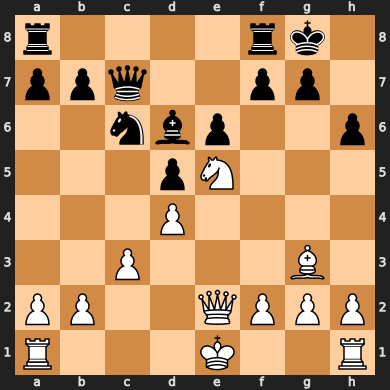

5rk1/2r2ppp/p2bpn2/3p4/q2P4/1NP3P1/P1RNQPP1/4R1K1 b - - 0 1


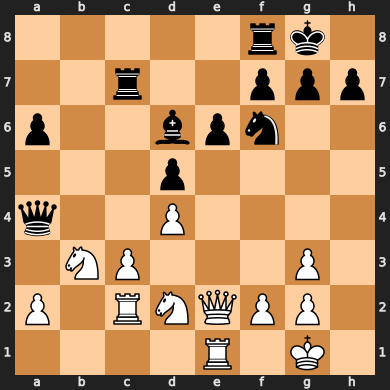

r4rk1/ppqn1ppp/3bp3/3p4/3P4/2P3P1/PP1NQPPN/R4RK1 b - - 0 1


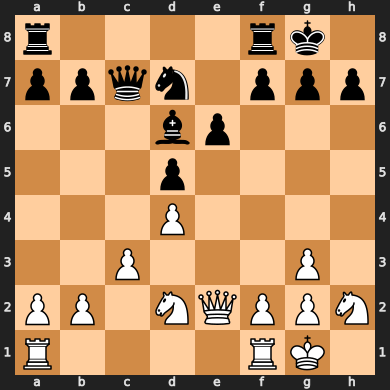

r1b2rk1/pp1nq1p1/2p1p2p/3p1p2/2PPn3/2N1PN2/PPQ1BPPP/R4RK1 w - - 0 1


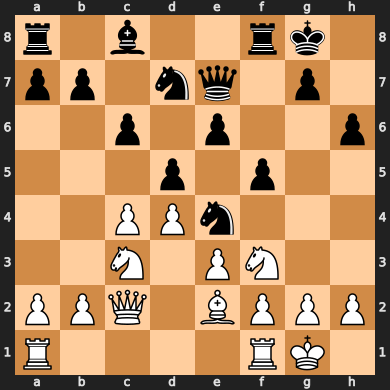

r3k2r/ppq2ppp/2nbpn2/3p2N1/3P4/2P3B1/PP1NQPPP/R3K2R b KQkq - 0 1


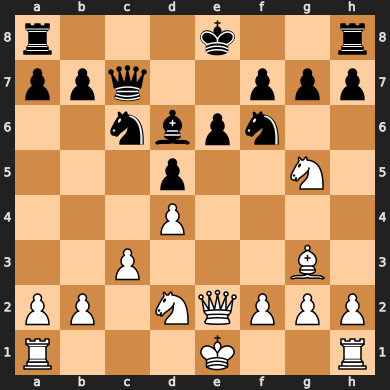

r4rk1/ppqn1pp1/2nbp2p/3pN3/3P4/2P2NB1/PP2QPPP/R3K2R b KQ - 0 1


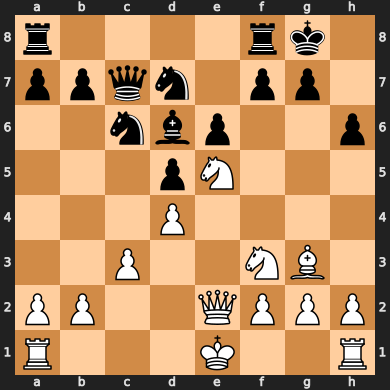

r4rk1/2qn1ppp/p2bp3/1p1p4/3P4/2P2NP1/PP1NQPP1/R3R1K1 b - - 0 1


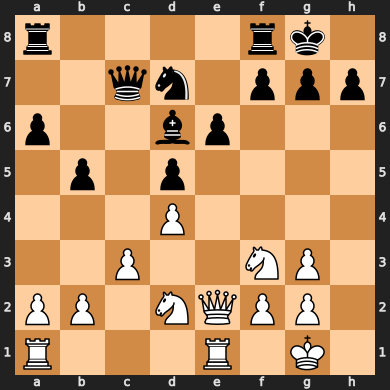

2r2rk1/5ppp/p2bpn2/q2p4/3P4/2P3P1/P1RNQPP1/1N2R1K1 b - - 0 1


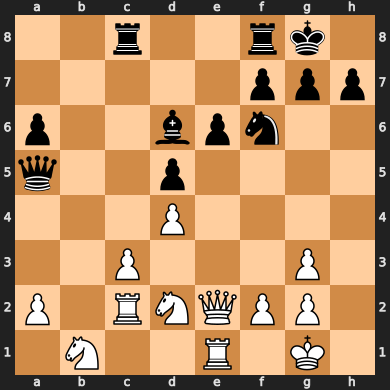

r4rk1/ppqn1ppp/3bp3/2pp4/3P4/2P1P1P1/PP1NQPPN/R4RK1 b - - 0 1


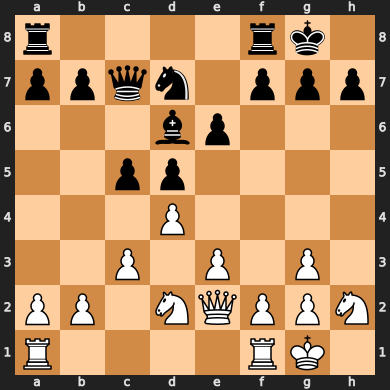

r1b2rk1/pp1nqpp1/2p1p2p/3p4/2PPn3/2N1PN2/PP2BPPP/R2Q1RK1 w - - 0 1


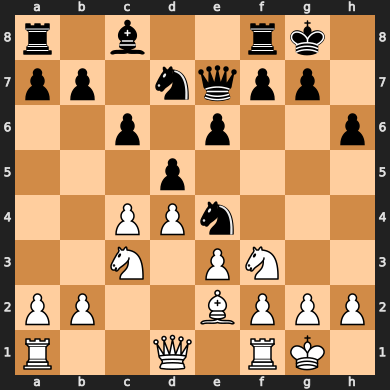

5rk1/1pq2ppp/p1nbrn2/3p4/P1pP4/2P4P/1PBN1PP1/R1BQR1K1 b - - 0 1


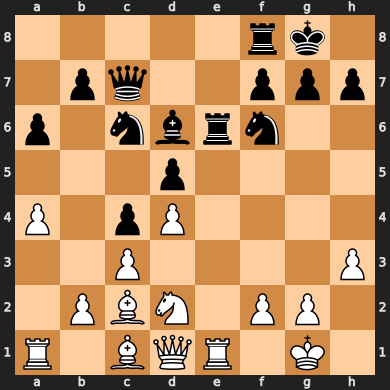

r1bq1rk1/pp1n2pp/2p1p3/3p1p2/2PPnB2/2PBPN2/P1Q2PPP/R4RK1 w - - 0 1


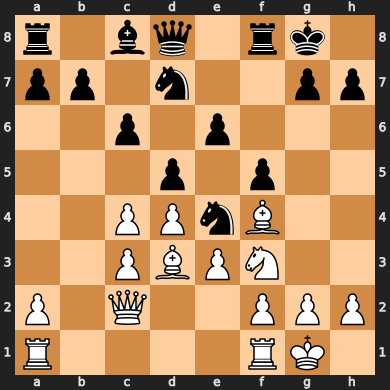

5rk1/2r2ppp/p2bpn2/q2p4/3P4/1NP3P1/P1R1QPP1/1N2R1K1 b - - 0 1


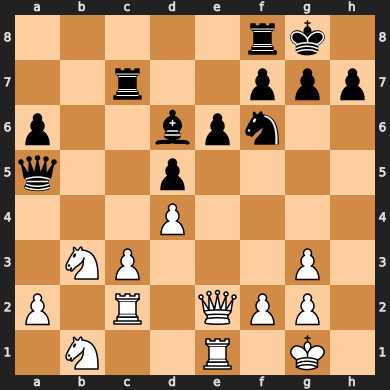

r4rk1/2qn1ppp/p2bp3/3p4/3P4/2P2NP1/P2NQPP1/2R1R1K1 b - - 0 1


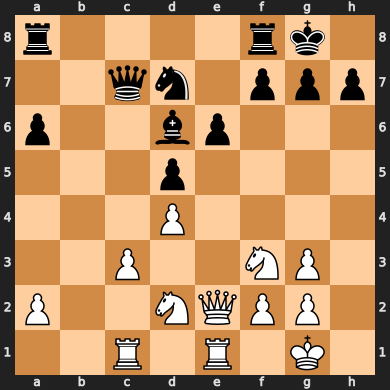

r4rk1/2p2ppp/p1Qb1n2/3pNq1b/1P1P4/2P4P/P2N1PP1/R1B1R1K1 b - - 0 1


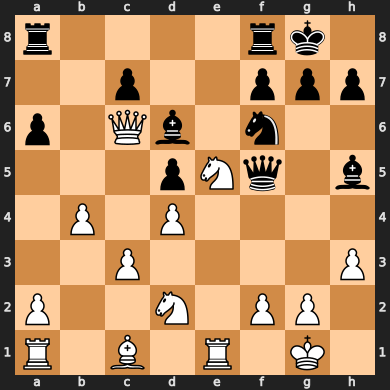

r1bq1rk1/pp1n2pp/4p3/3p1p2/3PnB2/2PBPN2/P1Q2PPP/R4RK1 w - - 0 1


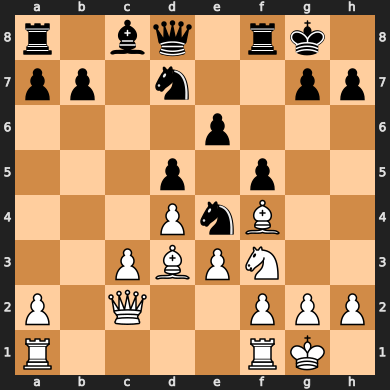

r1bq1rk1/pp2bpp1/2n1pn1p/3pN3/3P4/2PB4/PP1N1PPP/R1BQR1K1 b - - 0 1


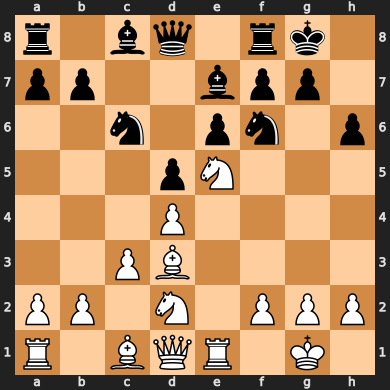

r2q1rk1/pp3ppp/3bpn2/3pNP2/3P4/6P1/PP1N1PBP/n1BQR1K1 b - - 0 1


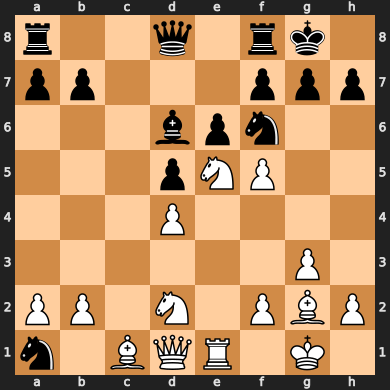

r1b2rk1/pppq1ppp/2nbpn2/3p4/3P4/2PBPN2/PP1NQPPP/R1B2RK1 b - - 0 1


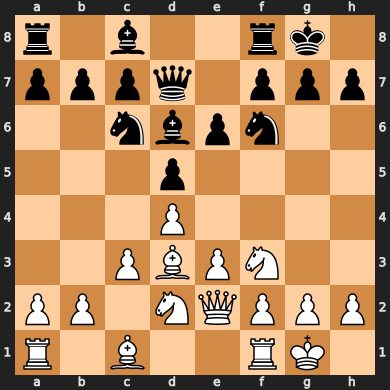

r4rk1/2qn1ppp/p2bp3/3p4/1p1P4/2P2NP1/PP1NQPP1/2R1R1K1 b - - 0 1


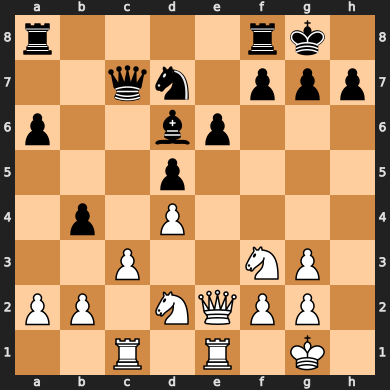

r2q1rk1/pp3ppp/3bpn2/3pNb2/3PP3/6P1/PPnN1PBP/R1BQR1K1 b - - 0 1


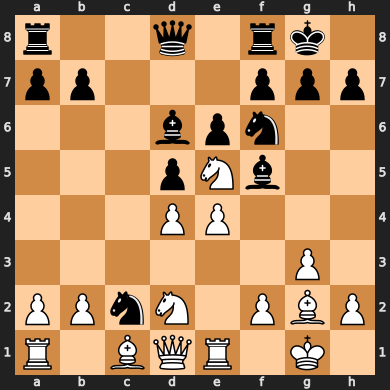

r3k2r/ppq2pp1/2nbpn1p/3p4/3P4/2P2NB1/PP1NQPPP/R3K2R b KQkq - 0 1


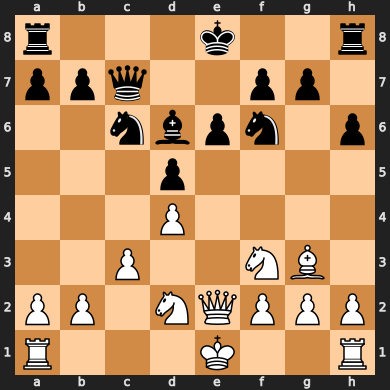

r4rk1/ppq2pp1/3bp2p/3pB3/3P4/2P5/PP2QPPP/R3K2R b KQ - 0 1


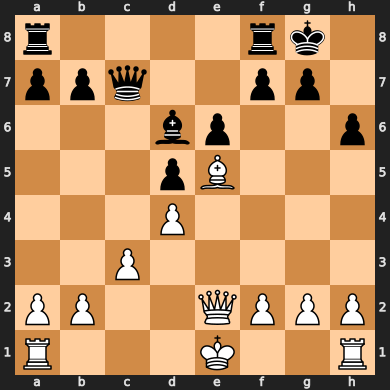

In [11]:
printable_query_array = reverse_orient_board(query_array)
print(vector_to_fen(printable_query_array))
display(chess.Board(fen=query_fen))
print('-'*64)

for ind in top_k_indices:
    fen_array = all_board_csr_matrix[ind]
    vector = reverse_orient_board(fen_array.toarray()[0])
    fen_string = vector_to_fen(vector)
    print(fen_string)
    display(chess.Board(fen=fen_string))